## <center> Data Preparation </center>

Sample data: 

* 
> “A-M-A-ZING!!!!!!!!!!!!!! LOVE THIS PLACE!!!!!!! Everything on the menu looked so good!! Garlic chicken was the BOMB!!!!!! MUST EAT AT THIS PLACE!!! I recommend ordering ahead before you go! Gets very busy!!!” — 5 Stars.

* 
> “burgers are very big portions here. definitely order the onion ring tower to share…Milkshakes are tasty! My personal favourite — the vanilla one.” — 3 Stars.

* 
> “Food is very bland — not authentic at all. meant to cater to the customers who have never eaten Vietnamese food before. Definitely will not be returning!” — 1 Stars

The first part of the project is to prepare the data. As we saw in the examples above, the reviews are very distinct. 
* Some of them have symbols, 
* have weird punctuation symbols, 
* and some even have non-alphanumeric characters. 

We will clean these and keep the most relevant strings and words from the reviews. 

## Importing libraries

Importing necessary libraries to assist us in data preparation

In [26]:
import pandas as pd    # to create a dataframe from JSON datafile
import json            # to read the dataset, because dataset is initially in the JSON format
import numpy as np     # to handle large python list as numpy arrays - makes the process faster. Used in creating dataFrame
import matplotlib.pyplot as plt # to draw plot - for visualization
from collections import Counter # to counter class distribution in the dataset
import re              # for data cleaning

pd.set_option('max_colwidth', 300,"html.border",2)  # For aesthetic purposes
from IPython.display import display, HTML           # For aesthetic purposes

## Read the dataset

The dataset downloaded from yelp is in JSON format as below:  
    
* > {"review_id":"v0i_UHJMo_hPBq9bxWvW4w","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"0W4lkclzZThpx3V65bVgig","stars":5,"date":"2016-05-28","text":"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.","useful":0,"funny":0,"cool":0}

* > {"review_id":"vkVSCC7xljjrAI4UGfnKEQ","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"AEx2SYEUJmTxVVB18LlCwA","stars":5,"date":"2016-05-28","text":"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.","useful":0,"funny":0,"cool":0}

It is  a 4.2G file - *review.json* 

I plan to just read the *text* and *stars* from the review and build a pandas dataset out of it.

Let's do this.

In [38]:
def readData(reviewJsonFilePath, outputDataFrameFilePath):
    df = pd.DataFrame(columns=['review','stars'])
    reviews = []    # Aggregated list of reviews
    stars = []      # Aggregated list of stars
    with open(reviewJsonFilePath, "r") as f:
        number_of_records = 0
        for line in f:
            line = json.loads(line)
            reviews.append(line["text"])
            stars.append(line['stars'])
            number_of_records += 1
            
        df["review"] = reviews
        df["stars"] = stars
        
    print ("Number of records read : {0}".format(number_of_records))      
    print ("Sample data : ")
    display(df.head())
    return df
                
            
reviewJsonFilePath = "../data/review.json"
outputDataFrameFilePath = "../data/dataset.csv"
df = readData(reviewJsonFilePath, outputDataFrameFilePath)            

Number of records read : 5261669
Sample data : 


,review,stars
0,"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.",5
1,Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.,5
2,Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how...,5
3,Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the inside. \n\nThe smoked meat is up there in quali...,5
4,"Love coming here. Yes the place always needs the floor swept but when you give out peanuts in the shell how won't it always be a bit dirty. \n\nThe food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger ...",4


In [39]:
## Saving the dataset file onto disk for future use
df.to_csv(outputDataFrameFilePath, index=False)

## Class distribution

Let us look at the class distribution of label - *stars* in our case

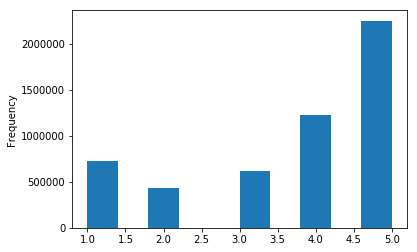

In [2]:
#df = pd.read_csv("../data/dataset.csv")
df['stars'].plot.hist()
plt.show()

In [12]:
c = Counter(df['stars'])
print (c)
print ("Percentage distribution of labels : ")
[(i, c[i] / len(df) * 100.0) for i in c]

Counter({5.0: 2253348, 4.0: 1223316, 1.0: 731363, 3.0: 615481, 2.0: 438161, nan: 1, nan: 1})
Percentage distribution of labels : 


[(nan, 1.900536920685463e-05),
 (1.0, 13.899823839232821),
 (2.0, 8.327411577044632),
 (3.0, 11.697443644804094),
 (4.0, 23.249572236652575),
 (5.0, 42.82571069152746),
 (nan, 1.900536920685463e-05)]

There is definately a class bias :
* 14% of the label values are for stars 1
* 8% of the label values for stars 2
* 12% of the label values for stars 3
* 23% of the label values for stars 4
* 42% of the label values for stars 5



## Sampling

We are looking at 2 criteria when creating the dataset for training and testing purposes. 

* First, we skip over all reviews that have 3 stars, because they are neutral and we are only predicting positive or negative sentiment. 
* The second criteria is maintaining equal number of positive and negative reviews. 

If you load in the data directly, you’ll notice that there are a lot more + reviews than — reviews, with almost a 70%-30% split. We want to keep our training data equally balanced. 

In the code below, we sample the same number of reviews, which in this case is 200,000 for each sentiment (positive and negative) : 
* 100,000 - stars 1 (negative sentiment) 
* 100,000 - stars 2 (negative sentiment)
* 100,000 - stars 4 (positive sentiment)
* 100,000 - stars 5 (positive sentiment)

In [3]:
## Shufling the dataset
df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,review,stars
0,"I had a bad experience with a competitor dentist, who refused to provide a standard cleaning. I had shopped around and read countless reviews to find a good dentist. \n\nIts a big office with 10+ dentists. The hygienists are great and well trained. They handle all the billing and scheduling righ...",5.0
1,This is the closest UPS Store to me and about three years ago I had a bad experience and stopped going there. \n\nBasically I was was told the notary would be there at X o'clock and when I went there they told me to my face that they would have NEVER quoted me that time and that person does not ...,4.0
2,"I am absolutely in love with Sambalatte's cappuccino. It's fresh, dark and rich. If you like light and nutty tastes, this is not for you. If you enjoy dark coffee with some milk and foam, you can't go wrong.\n\nThe shop is very photogenic and the coffee mugs were adorable. It has ""Las Vegas' on ...",5.0
3,"My wife and I accidentally stumbled upon this place when going to see a movie one afternoon. We love sushi, saw the word sushi, and decided to head in and we were not disappointed. The atmosphere was nice. The sushi chefs constantly engaged us in humorous and witty conversation. The fish was fre...",2.0
4,Came here during Speedstreet. Needed a place to sit and relax. Was seated promptly. They have a great craft beer selection and we needed some assistance in understanding the various offerings. Waiter was spot on with his recommendations. Pizza was ordered. They were very busy and the food order ...,4.0


In [4]:
negative1 = df[df["stars"]==1].head(100000)
negative2 = df[df["stars"]==2].head(100000)

positive1 = df[df["stars"]==4].head(100000)
positive2 = df[df["stars"]==5].head(100000)

del df   # freeing up memory

df = pd.DataFrame()
df = df.append(negative1)
df = df.append(negative2)
df = df.append(positive1)
df = df.append(positive2)

del negative1
del negative2
del positive1
del positive2

df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
df.head()

,review,stars
0,"Terrible service. With a 30 minute wait, my two friends and I went to the bar to grab a drink. The bartender didn't pay us (or any other patrons) a second of attention for the whole 25 minutes that we waited at the bar. Once we were seated outside, it took about 20 minutes to get our margaritas,...",2.0
1,Be a single woman customer at the bar before the arts and letters series and learn about poor and maybe gender biased service. Terrible and dismissive service. I won't be back.,1.0
2,"just an FYI, when I went they were no longer serving their carpaccio and marrow dish as their guy can't source good marrow anymore. Bummer. \n\nwe had a seared tuna app to start and it was great. lots of sweet/citrus flavours with the tuna. Really good and refreshing. \n\nshared the cacio e pep...",4.0
3,Went there for lunch with my mother - her first time at an Indian restaurant - service and food was really good. Will definitely be back.,4.0
4,We show up about 2 o'clock on a Tuesday and it's pretty slow. When we pulled up there was nobody out front to write our ticket. Sat there in the car for a couple minutes when finally a guy walked out. He's got his phone in his hand and takes his sweet time walking to the car so he can finish his...,1.0


## Data cleaning

Now, for cleaning the data, we take the following steps:

* remove non alpha-numeric characters, 
* remove punctuation, 
* lower-case each word 
    

In [25]:
df['review'] = df['review'].apply(lambda x:re.sub(r'\W+', " ",x))
df['review'] = df['review'].apply(lambda x:x.lower())
df.head()

,review,stars
0,terrible service with a 30 minute wait my two friends and i went to the bar to grab a drink the bartender didn t pay us or any other patrons a second of attention for the whole 25 minutes that we waited at the bar once we were seated outside it took about 20 minutes to get our margaritas and an ...,2.0
1,be a single woman customer at the bar before the arts and letters series and learn about poor and maybe gender biased service terrible and dismissive service i won t be back,1.0
2,just an fyi when i went they were no longer serving their carpaccio and marrow dish as their guy can t source good marrow anymore bummer we had a seared tuna app to start and it was great lots of sweet citrus flavours with the tuna really good and refreshing shared the cacio e pepe pasta and toa...,4.0
3,went there for lunch with my mother her first time at an indian restaurant service and food was really good will definitely be back,4.0
4,we show up about 2 o clock on a tuesday and it s pretty slow when we pulled up there was nobody out front to write our ticket sat there in the car for a couple minutes when finally a guy walked out he s got his phone in his hand and takes his sweet time walking to the car so he can finish his te...,1.0


## Encode text

With cleaned reviews, we now need to generate embeddings for each review. Text data as we have now cannot be directly fed into the model, so we need to: 

* encode each word to a unique numerical value. 

So, a review will be converted from being an array of words to an array of integer values. This can be done by adding an Embedding layer onto the network, but we need to generate that embedding map first.

* Keras provides a Tokenizer module which we can use to encode the texts. 
* After converting the texts to sequences, we can obtain the word_index. 
* We also need the reverse dictionary, so let’s build that as well. 

After this, we can generate encoded reviews by iterating through the texts, and mapping each word to it’s embedding value.

In [27]:
# Complete this part of the code